# Forecasting for Banking Using Time Series Methods, Live Classes Python notebook
this notebook...


## Live Class 1

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import statsmodels.api as sm

In [3]:
# Load the Excel file with all worksheets
file_path = r"/Users/hugo/Python/bsi_dataset.xlsx" #r"C:\Users\hbourrou\Python\Data\bsi_dataset.xlsx"

# Load the data into a dictionary of dataframes (the None option for sheet_name creates a dictionary of dataframes)
excel_data = pd.read_excel(file_path, sheet_name=None)

# Extract worksheet names and display info to make sure everything worked fine
sheet_names = list(excel_data.keys())
print(f"Found {len(sheet_names)} worksheets: {sheet_names}")

Found 6 worksheets: ['BSI', 'GDP', 'int rate short', 'int rate long', 'Comp ind syst stress', 'HICP']


### Cleaning data
Below we work on the individual dataframes to make them consistent.   
The analysis focuses on Germany, and the monthly variables (interest rates, CISS) are converted to quarterly by averaging observations within quarters.

**Note:** for this type of easy dataset, it would be cleaner to do the treatment directly in Excel (i.e. import here only the relevant variables for Germany)

In [272]:
# create a dataframe for each worksheet and clean after
for i, (sheet_name, df) in enumerate(excel_data.items()):
    locals()[f"df{i+1}"] = df

In [274]:
# Ok, let's do the dirty cleaning now
df1.head(5)

,Unnamed: 0,"Germany, Loans, Total, Euro area (changing composition), Unspecified counterpart sector","Spain, Loans, Total, Euro area (changing composition), Unspecified counterpart sector","France, Loans, Total, Euro area (changing composition), Unspecified counterpart sector","Italy, Loans, Total, Euro area (changing composition), Unspecified counterpart sector","Germany, Deposit liabilities, Total, Euro area (changing composition), Unspecified counterpart sector","Spain, Deposit liabilities, Total, Euro area (changing composition), Unspecified counterpart sector","France, Deposit liabilities, Total, Euro area (changing composition), Unspecified counterpart sector","Italy, Deposit liabilities, Total, Euro area (changing composition), Unspecified counterpart sector","Germany, Capital and reserves, World not allocated (geographically), Unspecified counterpart sector","Spain, Capital and reserves, World not allocated (geographically), Unspecified counterpart sector","France, Capital and reserves, World not allocated (geographically), Unspecified counterpart sector","Italy, Capital and reserves, World not allocated (geographically), Unspecified counterpart sector"
0,NaN,(Millions of Euro),(Millions of Euro),(Millions of Euro),(Millions of Euro),(Millions of Euro),(Millions of Euro),(Millions of Euro),(Millions of Euro),(Millions of Euro),(Millions of Euro),(Millions of Euro),(Millions of Euro)
1,1997-Q4,3415366,NaN,NaN,NaN,2987309,NaN,NaN,NaN,197963,NaN,NaN,NaN
2,1998-Q1,3435838,NaN,NaN,NaN,3005318,NaN,NaN,NaN,202938,NaN,NaN,NaN
3,1998-Q2,3517512,NaN,NaN,NaN,3064839,NaN,NaN,NaN,207787,NaN,NaN,NaN
4,1998-Q3,3566887,NaN,NaN,NaN,3088691,NaN,NaN,NaN,207969,NaN,NaN,NaN


so what has to be done:
- drop the first row
- deal with the index
- keep only the variables related to Germany and remane them appropriately

In [277]:
df1 = df1.drop(index=0).reset_index(drop=True)
df1 = df1.set_index(pd.to_datetime(df1['Unnamed: 0']))
df1.index.name = 'date'

de_columns = [col for col in df1.columns if 'Germany' in col]
df1 = df1[de_columns]

# rename the column so that match the EViews script
df1.columns = ['de_loan', 'de_dep', 'de_cap']
df1 = df1.apply(pd.to_numeric, errors='coerce') # this converts to numeric variables (not stored like this)
df1.head(5)

/var/folders/5g/45nql5kj3fsc42f1td53mt0w0000gn/T/ipykernel_14172/3571834084.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df1 = df1.set_index(pd.to_datetime(df1['Unnamed: 0']))


,de_loan,de_dep,de_cap
date,,,
1997-10-01,3415366,2987309,197963
1998-01-01,3435838,3005318,202938
1998-04-01,3517512,3064839,207787
1998-07-01,3566887,3088691,207969
1998-10-01,3698872,3237024,212630


Now we do the same thing for the other 5 data frames...

In [280]:
# df2: GDP
df2 = df2.drop(index=0).reset_index(drop=True)
df2 = df2.set_index(pd.to_datetime(df2['Unnamed: 0']))
df1.index.name = 'date'

de_columns = [col for col in df2.columns if 'Germany' in col]
df2 = df2[de_columns]
df2 = df2.rename(columns={df2.columns[0]: 'de_gdp'})
df2 = df2.apply(pd.to_numeric, errors='coerce')
df2.head(5)

/var/folders/5g/45nql5kj3fsc42f1td53mt0w0000gn/T/ipykernel_14172/245368490.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df2 = df2.set_index(pd.to_datetime(df2['Unnamed: 0']))


,de_gdp
Unnamed: 0,
1997-10-01,506217.29
1998-01-01,481205.72
1998-04-01,492703.92
1998-07-01,509263.72
1998-10-01,521496.95


In [282]:
# df3: short interest rates
# Here the data are at the monthly frequency, so we need to take care of that and average over each quarter
df3 = df3.drop(index=0).reset_index(drop=True)
df3 = df3.set_index(pd.to_datetime(df3['Unnamed: 0'], format='%Y-%m'))
df3.index.name = 'date'

de_columns = [col for col in df3.columns if 'Germany' in col]
df3 = df3[de_columns]
df3 = df3.rename(columns={df3.columns[0]: 'de_ints'})
df3 = df3.apply(pd.to_numeric, errors='coerce')
df3 = df3.resample('QE').mean()
df3.head(5)

,de_ints
date,
2000-03-31,2.730000
2000-06-30,2.730000
2000-09-30,2.743333
2000-12-31,2.743333
2001-03-31,2.740000


In [284]:
# df4: long interest rates
# Here the data are at the monthly frequency, so we need to take care of that and average over each quarter
df4 = df4.drop(index=0).reset_index(drop=True)
df4 = df4.set_index(pd.to_datetime(df4['Unnamed: 0'], format='%Y-%m'))
df4.index.name = 'date'

de_columns = [col for col in df4.columns if 'Germany' in col]
df4 = df4[de_columns]
df4 = df4.rename(columns={df4.columns[0]: 'de_intl'})
df4 = df4.apply(pd.to_numeric, errors='coerce')
df4 = df4.resample('QE').mean()
df4.head(5)

,de_intl
date,
1997-12-31,5.490000
1998-03-31,5.000000
1998-06-30,4.886667
1998-09-30,4.386667
1998-12-31,4.013333


In [286]:
# df5: 'Comp ind syst stress', also monthly
df5 = df5.drop(index=0).reset_index(drop=True)
df5 = df5.set_index(pd.to_datetime(df5['Unnamed: 0'], format='%Y-%m'))
df5.index.name = 'date'

de_columns = [col for col in df5.columns if 'Germany' in col]
df5 = df5[de_columns]
df5 = df5.rename(columns={df5.columns[0]: 'de_ciss'})
df5 = df5.apply(pd.to_numeric, errors='coerce')
df5 = df5.resample('QE').mean()
df5.head(5)

,de_ciss
date,
2000-09-30,0.108300
2000-12-31,0.105200
2001-03-31,0.082767
2001-06-30,0.089267
2001-09-30,0.058867


In [288]:
# df6: HICP, also monthly
df6 = df6.drop(index=0).reset_index(drop=True)
df6 = df6.set_index(pd.to_datetime(df6['Unnamed: 0'], format='%Y-%m'))
df6.index.name = 'date'

de_columns = [col for col in df6.columns if 'Germany' in col]
df6 = df6[de_columns]
df6 = df6.rename(columns={df6.columns[0]: 'de_hicp'})
df6 = df6.apply(pd.to_numeric, errors='coerce')
df6 = df6.resample('QE').mean()
df6.head(5)

,de_hicp
date,
1997-12-31,0.516667
1998-03-31,0.206667
1998-06-30,0.296667
1998-09-30,0.213333
1998-12-31,0.116667


In [292]:
# Finally, we merge all the dataframe to make a final one

# First, we convert all the index explicitely to quarterly to avoid bugs with dates
for df_name in ['df1', 'df2', 'df3', 'df4', 'df5', 'df6']:
    df = locals()[df_name]
    locals()[df_name].index = df.index.to_period('Q')
    
final_df = pd.concat([df1, df2, df3, df4, df5, df6], axis=1)
final_df.head(10)

,de_loan,de_dep,de_cap,de_gdp,de_ints,de_intl,de_ciss,de_hicp
1997Q4,3415366.0,2987309.0,197963.0,506217.29,NaN,5.490000,NaN,0.516667
1998Q1,3435838.0,3005318.0,202938.0,481205.72,NaN,5.000000,NaN,0.206667
1998Q2,3517512.0,3064839.0,207787.0,492703.92,NaN,4.886667,NaN,0.296667
1998Q3,3566887.0,3088691.0,207969.0,509263.72,NaN,4.386667,NaN,0.213333
1998Q4,3698872.0,3237024.0,212630.0,521496.95,NaN,4.013333,NaN,0.116667
1999Q1,3663429.0,3153883.0,218397.0,495250.00,NaN,3.863333,NaN,0.090000
1999Q2,3728913.0,3200743.0,227867.0,507670.00,NaN,4.073333,NaN,0.183333
1999Q3,3816760.0,3253088.0,232738.0,524670.00,NaN,4.866667,NaN,0.236667
1999Q4,3878472.0,3302450.0,236956.0,537290.00,NaN,5.160000,NaN,0.370000
2000Q1,3892954.0,3330627.0,241791.0,515500.00,2.73,5.460000,NaN,0.546667


### Graphical Analysis

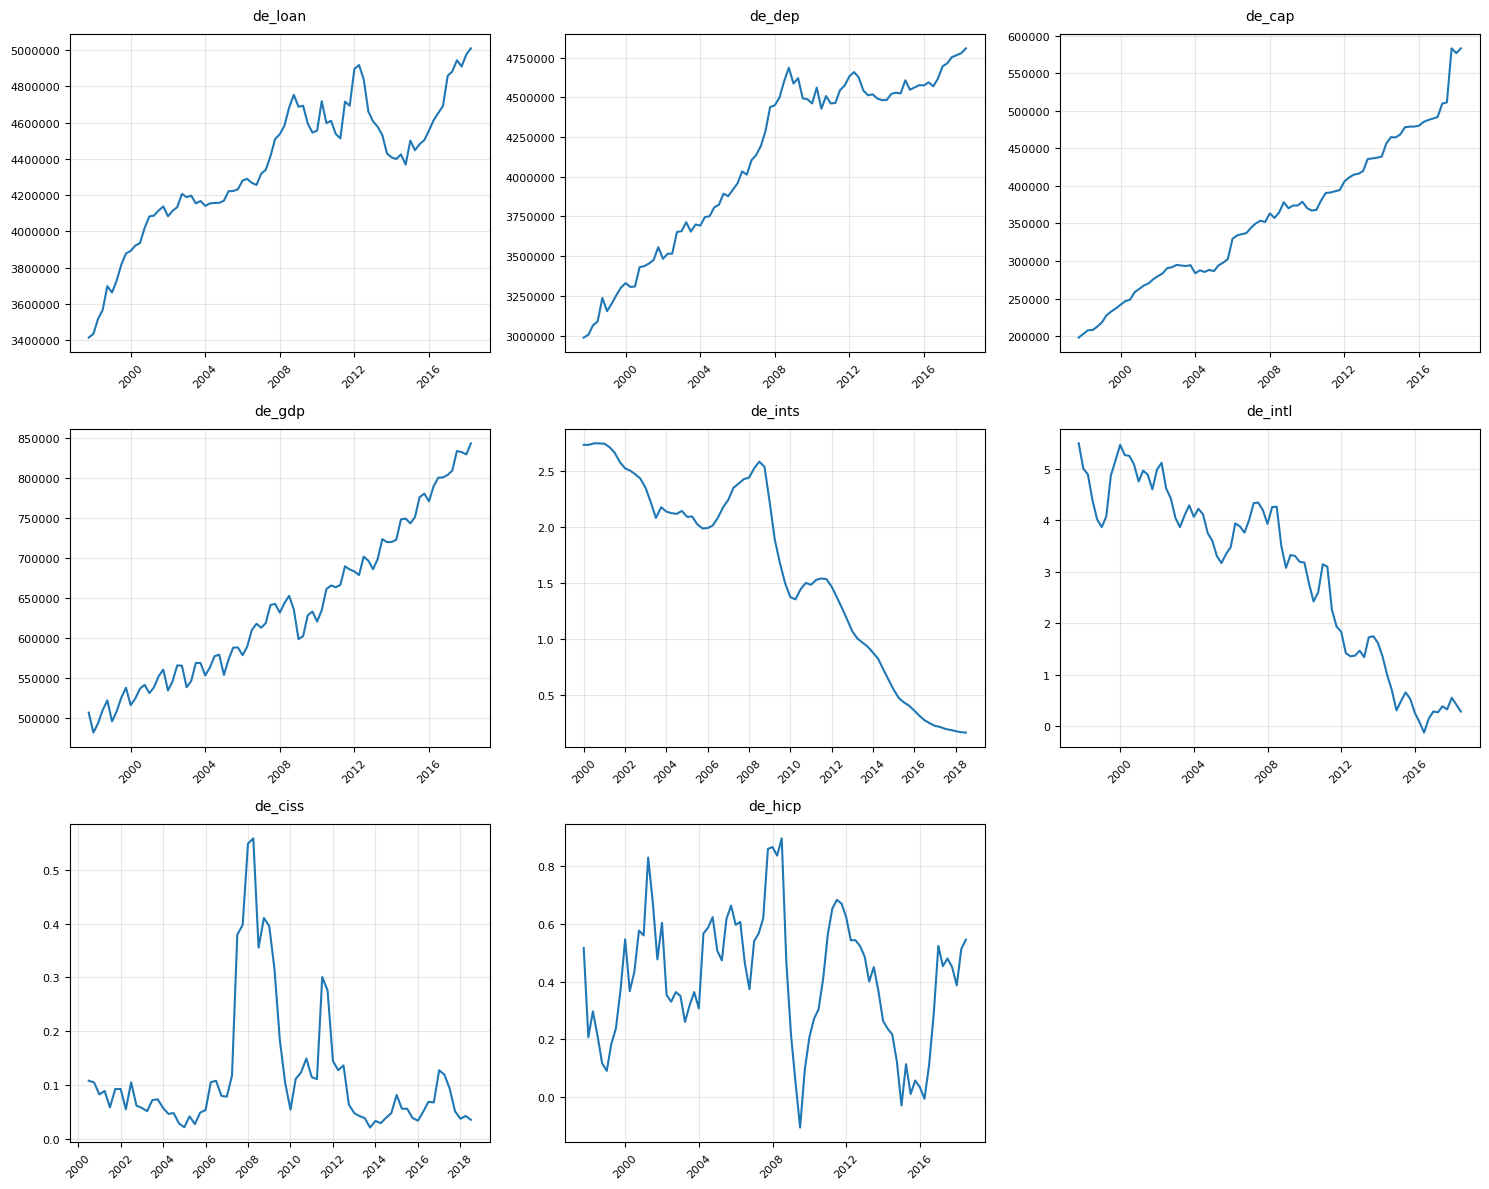

In [296]:
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes_flat = axes.flatten()
columns = final_df.columns.tolist()
for i, col in enumerate(columns):
    ax = axes_flat[i]
    x_values = final_df.index.to_timestamp() if hasattr(final_df.index, 'to_timestamp') else final_df.index
    ax.plot(x_values, final_df[col], linewidth=1.5)
    ax.set_title(col, fontsize=10, pad=10)
    ax.grid(True, alpha=0.3)
    
    ax.tick_params(axis='x', rotation=45, labelsize=8)
    ax.tick_params(axis='y', labelsize=8)
    
    ax.ticklabel_format(style='plain', axis='y')

# Hide the extra subplot (since we have 8 variables in a 3x3 grid)
axes_flat[8].set_visible(False)
plt.tight_layout()
plt.show()


In [ ]:
# There is clear seasonality in GDP, but it doesn't matter since if needed we'll work with yoy growth rates


## Live Class 2